# Recasting CTAO Projected Upper Limits Notebook

This notebook reproduces the **recasting** of published CTAO projected upper limits (ULs) on dark-matter (DM) annihilation channels.

In particular we will use as an example, the ULs of the following CTAO publication

Acharyya, Atreya, et al. "Sensitivity of the Cherenkov Telescope Array to a dark matter signal from the Galactic centre." Journal of cosmology and astroparticle physics 2021.01 (2021): 057.


https://arxiv.org/pdf/2007.16129  Figure 5




> Tip: Run the notebook top-to-bottom from a fresh kernel to ensure reproducibility.


## Imports & Setup <a id='Imports-Setup'></a>


In [1]:
# --- Imports & Setup: see preceding markdown for context ---
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.table import Table
from scipy  import optimize
from scipy  import integrate

## Gammapy PrimaryFlux
gammapy version 1.2


In [2]:
from gammapy.astro.darkmatter import  PrimaryFlux

## Recast Class <a id='Helper-Functions'></a>


In [3]:
class Recast_ULs:
    """
    Recast published upper limits (ULs) from one DM annihilation channel/model to another,
    using the approximate IRF-free procedure based on photon yields integrated per energy bin.

    This class estimates the (unknown) per-bin coefficients proportional to A_eff / sqrt(b)
    — encoded here as a relative vector V — by *fitting* them with two benchmark channels.
    Once those coefficients are inferred, it applies the ratio formula to
    recast the ULs from a reference channel to a target channel.

    Parameters
    ----------
    DM_masses : astropy.units.Quantity
        Array of DM masses (bin centers), with units convertible to GeV.
        Assumed sorted ascending and *defining* the reconstructed-energy binning used in the ULs.
    UL_values : np.ndarray
        Published upper limits (ULs) for the reference channel/model M0, one value per mass bin.
        Shape: (n_bins,).
    spectral_model_in : list
        List of spectral models (callables with `.evaluate(energy)`) for the **reference** channel M0,
        one per mass bin. Each returns dN/dE with units 1/GeV when evaluated on energies.
    spectral_model_out : list
        List of spectral models (same interface) for the **target** channel M1,
        one per mass bin, producing dN/dE for that bin's DM mass hypothesis.
    spectral_model_in2 : list
        List of spectral models for the **second benchmark** channel M2
        (used only to *fit* the V coefficients against UL_values_2).
    UL_values_2 : np.ndarray
        Published ULs for the second benchmark channel M2, one per mass bin.

    Notes
    -----
    - This implementation follows the approximate recasting in which the instrument
      information (A_eff, energy-dispersion, bkg) enters *only* through a per-bin factor
      proportional to A_eff / sqrt(b). The relative vector V is fitted using the
      ratio of ULs between two channels (M0 and M2), then reused to recast M0 -> M1.
    - The energy binning is inferred from the provided DM_masses by constructing borders
      in log-space and using geometric means as bin centers.
    - Each spectral model is evaluated on a fine grid inside each bin and integrated
      with Simpson's rule to obtain ΔN_gamma per bin.
    - All energies are handled in GeV; dN/dE is converted to 1/GeV before integration.
    """

    def __init__(self,
                 DM_masses,
                 UL_values,
                 spectral_model_in,
                 spectral_model_out,
                 spectral_model_in2,
                 UL_values_2):

        # --- Units and inputs
        self.energy_unit = u.GeV

        # Convert masses to GeV (float array)
        self.DM_masses          = DM_masses.to(self.energy_unit).value
        self.UL_values          = np.asarray(UL_values)
        self.spectral_model_in  = spectral_model_in     # reference channel (M0)
        self.spectral_model_out = spectral_model_out    # target channel    (M1)
        self.UL_values_2        = np.asarray(UL_values_2)
        self.spectral_model_in2 = spectral_model_in2    # second benchmark  (M2)

        # --- Build energy bin borders/centers from mass grid (log-uniform assumption)
        # Infer a "left border" by extrapolating the first log-step backward
        logm      = np.log10(self.DM_masses)
        self.emin = 10**(logm[0] - np.diff(logm)[0])

        # Borders: [emin, m0, m1, ..., m_{n-1}]
        self.energy_borders = np.concatenate(([self.emin], self.DM_masses))
        # Centers as geometric mean of adjacent borders
        self.energy_centers = np.sqrt(self.energy_borders[1:] * self.energy_borders[:-1])

        # --- Precompute ΔN_gamma for each bin and for each model list
        # The matrices store, for each mass bin i, the integral of dN/dE over all bins j
        # (diagonal dominates if spill-over is negligible). Here we assume per-row = per-mass.
        n = len(self.energy_centers)
        self.Ngamma_in   = np.empty((n, n))  # for M0 (reference)
        self.Ngamma_out  = np.empty((n, n))  # for M1 (target)
        self.Ngamma_in2  = np.empty((n, n))  # for M2 (second benchmark)

        # Use a fine geometric grid inside each energy bin for robust integration
        x_values = np.geomspace(self.energy_borders[:-1], self.energy_borders[1:], 1000)

        for i in range(n):
            # Integrate ΔN_gamma for each row (mass bin i) over all bins j
            # Assumption: spectral_model_*[i] corresponds to DM mass in bin i.
            y_values = self.spectral_model_in[i].evaluate(x_values * self.energy_unit).to(1 / self.energy_unit).value
            self.Ngamma_in[i, :] = integrate.simpson(y_values, x=x_values, axis=0)

            y_values = self.spectral_model_in2[i].evaluate(x_values * self.energy_unit).to(1 / self.energy_unit).value
            self.Ngamma_in2[i, :] = integrate.simpson(y_values, x=x_values, axis=0)

            y_values = self.spectral_model_out[i].evaluate(x_values * self.energy_unit).to(1 / self.energy_unit).value
            self.Ngamma_out[i, :] = integrate.simpson(y_values, x=x_values, axis=0)

        # Numerical safety: negative integration artifacts are clipped to zero
        self.Ngamma_in[self.Ngamma_in < 0]     = 0.0
        self.Ngamma_out[self.Ngamma_out < 0]   = 0.0
        self.Ngamma_in2[self.Ngamma_in2 < 0]   = 0.0

        # --- Fit the relative per-bin coefficients (A_eff / sqrt(b)) up to a global factor
        # We set the first bin coefficient to 1 and fit the remaining n-1 entries ≥ 0.
        initial_guess = np.ones(n - 1)

        # Target = UL(M2)/UL(M0) (per bin), used to find V such that
        # sqrt(sum K0^2 / sum K2^2) matches this ratio in each mass bin.
        target = self.UL_values_2 / self.UL_values

        self.result = optimize.least_squares(
            self.residuals,
            initial_guess,
            args=(self.Ngamma_in, self.Ngamma_in2, target),
            bounds=(0, np.inf)  # enforce non-negativity
        )

        # Full coefficient vector: first entry fixed to 1 by convention (sets overall scale)
        self.V = np.concatenate(([1.0], self.result.x))

        # --- Compute the fraction of K's needed to recast UL(M0) -> UL(M1)
        fraction_of_Ks = self.compute_fraction_of_Ks(self.Ngamma_in, self.Ngamma_out, self.V)

        # Final recasted ULs for the target channel M1
        self.recasted_ULs = fraction_of_Ks * self.UL_values

    def compute_fraction_of_Ks(self,
                               Ngamma_in: np.ndarray,
                               Ngamma_out: np.ndarray,
                               V: np.ndarray) -> np.ndarray:
        """
        Compute the per-mass-bin factor:
            sqrt( sum_j (K_in[j]^2) / sum_j (K_out[j]^2) )
        using K ∝ ΔN_gamma * (A_eff / sqrt(b)) per bin.

        Parameters
        ----------
        Ngamma_in : np.ndarray
            Matrix of ΔN_gamma for the reference channel M0, shape (n_bins, n_bins).
        Ngamma_out : np.ndarray
            Matrix of ΔN_gamma for the target channel M1, shape (n_bins, n_bins).
        V : np.ndarray
            Vector of per-bin coefficients proportional to A_eff / sqrt(b),
            length n_bins. First element defines the overall scale.

        Returns
        -------
        np.ndarray
            Array of multiplicative factors (length n_bins) to recast ULs
            from M0 to M1 for each mass bin.
        """
        # sum_j [ (ΔN_gamma_in[i, j] * V[j])^2 ]
        summed_K_in  = np.sum((Ngamma_in  * V[np.newaxis, :])**2, axis=1)
        summed_K_out = np.sum((Ngamma_out * V[np.newaxis, :])**2, axis=1)

        return np.sqrt(summed_K_in / summed_K_out)

    def residuals(self,
                  V_reduced: np.ndarray,
                  Ngamma_in: np.ndarray,
                  Ngamma_out: np.ndarray,
                  target: np.ndarray) -> np.ndarray:
        """
        Residuals for the least-squares fit of the V vector (except the first bin).

        We define V = [1, a_1, ..., a_{n-1}] and solve for a_k >= 0 such that:
            compute_fraction_of_Ks(Ngamma_in, Ngamma_out, V) ≈ target,
        with target = UL(M2)/UL(M0) for each mass bin.

        Parameters
        ----------
        V_reduced : np.ndarray
            Optimization variable for bins [1..n-1]; bin 0 is fixed to 1.
        Ngamma_in : np.ndarray
            ΔN_gamma for M0 (reference), shape (n_bins, n_bins).
        Ngamma_out : np.ndarray
            ΔN_gamma for M2 (second benchmark), shape (n_bins, n_bins) — used for fitting.
        target : np.ndarray
            Ratio UL(M2)/UL(M0) per mass bin (length n_bins).

        Returns
        -------
        np.ndarray
            Residual vector to be minimized (length n_bins).
        """
        # Rebuild full vector with the first element fixed to 1 (sets scale)
        V = np.concatenate(([1.0], V_reduced))

        # Predicted ratio per mass bin for M0 -> M2, to match the published UL ratio
        pred = self.compute_fraction_of_Ks(Ngamma_in, Ngamma_out, V)

        # Residuals = predicted - target (element-wise)
        return pred - target

# Case we consider:
- channel to recast =   $W^+ W^-$
- benchmark channek =   $b \bar{b}$
- second benchmark channek =   $\tau^+ \tau^-$

## Load Data


In [11]:
# --- Load published CTAO ULs for the reference channel (bb) and
#     interpolate them to a common DM mass grid --------------------

# Read ECSV table with columns: [mass, UL] for Coma Berenices (bb channel)
t = Table.read('Limits/cta_2021_gc_ann_bb_sens.ecsv')

# Extract the DM mass column (astropy Quantity) and sort it ascending (safety)
mDM     = t[t.colnames[0]]
argsort = np.argsort(mDM)
mDM     = mDM[argsort]
mDM     = np.array(mDM) * mDM.unit  # ensure it's a Quantity array with units

# Extract the corresponding UL values (sigma_v upper limits), and sort consistently
sigma   = np.array(t[t.colnames[1]])
sigma   = sigma[argsort]

# Define a **common mass grid** (log-spaced) to which all channels will be interpolated
# Here: from 50 GeV up to the max mass of the bb table, using 12 points
DM_masses = np.geomspace(50 * u.GeV, mDM[-1], 12)

# Interpolate the bb ULs to the common mass grid (work in pure floats, keep units separate)
sigma_in = np.interp(
    DM_masses.to(u.GeV).value,  # x: target grid (GeV)
    mDM.to(u.GeV).value,        # xp: original grid (GeV)
    sigma                        # fp: UL values at xp
)
# NOTE: np.interp assumes xp is increasing (we sorted above). It performs linear interpolation
# in linear space. 


# --- Load second benchmark channel (tau tau) and interpolate to the same grid --------------

t = Table.read('Limits/cta_2021_gc_ann_tautau_sens.ecsv')

mDM     = t[t.colnames[0]]
argsort = np.argsort(mDM)
mDM     = mDM[argsort]

sigma   = np.array(t[t.colnames[1]])
sigma   = sigma[argsort]

sigma_in2 = np.interp(
    DM_masses.to(u.GeV).value,
    mDM.to(u.GeV).value,
    sigma
)


# --- Load the target channel (WW) and interpolate to the same grid ------------------------

t = Table.read('Limits/cta_2021_gc_ann_WW_sens.ecsv')

mDM     = t[t.colnames[0]]
argsort = np.argsort(mDM)
mDM     = mDM[argsort]

sigma   = np.array(t[t.colnames[1]])
sigma   = sigma[argsort]

sigma_out = np.interp(
    DM_masses.to(u.GeV).value,
    mDM.to(u.GeV).value,
    sigma
)

# At this point:
# - DM_masses (Quantity) is the unified mass grid
# - sigma_in  contains ULs for bb on that grid
# - sigma_in2 contains ULs for tau tau on that grid (used to fit A_over_b)
# - sigma_out contains ULs for WW on that grid (used as target comparison)
#
# These three arrays can be passed to Recast_ULs along with the spectral models to
# fit the per-bin coefficients and compute the recasted ULs.

## Recasting Computation <a id='Recasting-Computation'></a>


In [12]:
# --- Recasting Computation: bb → W using tau as secondary benchmark -----------------------
# Goal:
#   Recast published ULs from the bb channel (sigma_in) into ULs for the W channel,
#   using the tau channel (sigma_in2) to infer the per-bin coefficients A_eff/sqrt(b)
#   in the IRF-free approximation.

# Choose the *target* channel to recast to (CTAO nomenclature: 'W' ≡ W+W-)
channel_to_recast = 'W'

# Build per-mass spectral models dN/dE for:
#   - sp_in:   reference channel (bb), provides the "source" ULs to be recast
#   - sp_out:  target channel (W+W-), where we want the recasted ULs
#   - sp_in_2: second benchmark channel (tau), used ONLY to fit A_over_b coefficients
sp_out  = [PrimaryFlux(mDM=im, channel=channel_to_recast) for im in DM_masses]
sp_in   = [PrimaryFlux(mDM=im, channel='b')              for im in DM_masses]
sp_in_2 = [PrimaryFlux(mDM=im, channel='tau')            for im in DM_masses]

# Instantiate the recaster:
# Inputs:
#   - DM_masses:     common mass grid (Quantity, GeV)
#   - spectral_model_in:   models for reference channel (bb)
#   - spectral_model_out:  models for target channel   (W)
#   - UL_values:           published ULs for reference channel (bb) on the common grid
#   - UL_values_2:         published ULs for second benchmark (tau) on the same grid
#   - spectral_model_in2:  models for second benchmark (tau)
#
# What happens inside:
#   1) ΔN_gamma are integrated per energy bin for each mass and channel.
#   2) A_over_b (∝ A_eff / sqrt(b)) per-bin coefficients are *fitted* so that
#      the predicted bb→tau ratio reproduces the published UL ratio sigma_in2 / sigma_in.
#   3) Those coefficients are then used to compute the bb→W recasting factor and
#      generate recasted ULs for the W channel.
r = Recast_ULs(
    DM_masses=DM_masses,
    spectral_model_in=sp_in,        # reference (bb)
    spectral_model_out=sp_out,      # target (W)
    UL_values=sigma_in,             # ULs for bb
    UL_values_2=sigma_in2,          # ULs for tau (second benchmark)
    spectral_model_in2=sp_in_2      # spectra for tau
)

# Results available as:
#   r.recasted_ULs  → recasted ULs for the W channel on DM_masses grid
#   r.A_ober_b      → fitted per-bin coefficients (relative scale of A_eff/sqrt(b))
#   r.result        → least-squares optimization result (diagnostics)

/var/folders/cc/9yrg3qln5sq119c30p8bh2h00000gn/T/ipykernel_35978/59134382.py:154: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(summed_K_in / summed_K_out)


## Plot recasting


[1.69897    1.99849188 2.29801376 2.59753564 2.89705752 3.1965794
 3.49610128 3.79562316 4.09514504 4.39466692 4.6941888  4.99371068]


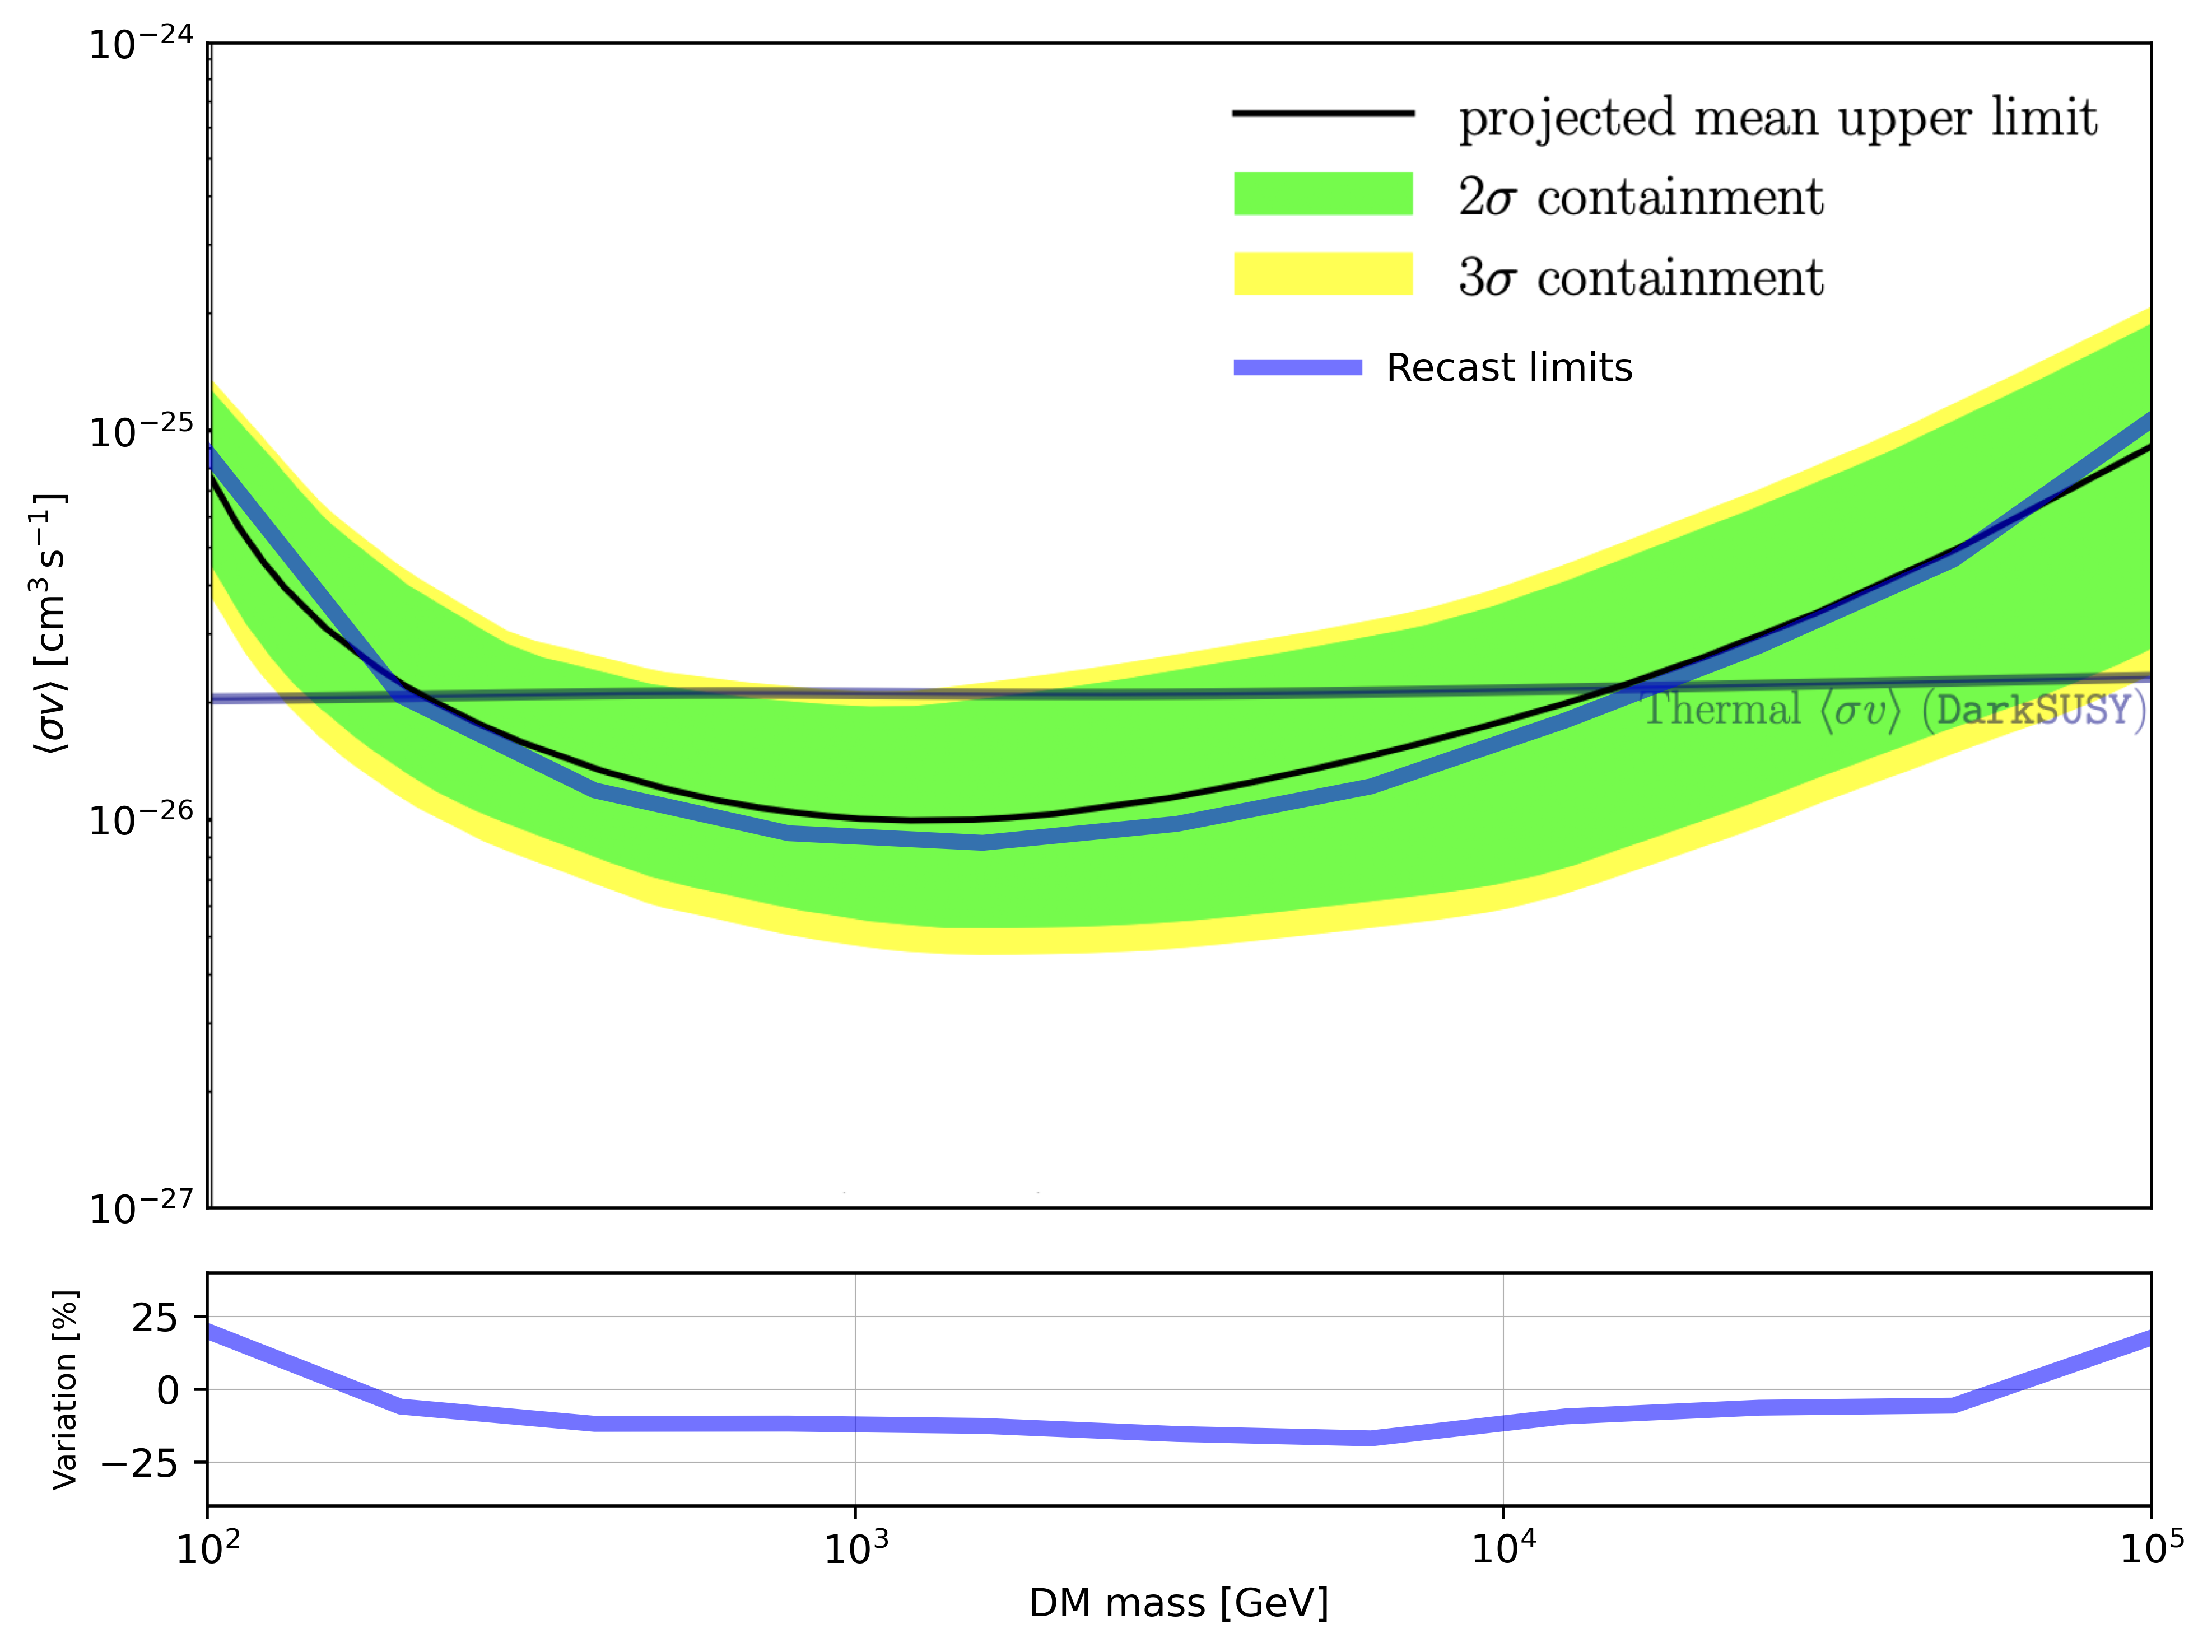

In [ ]:
# --- Plotting & Visualization: overlay recasted ULs on published CTAO figure -------------
# Goal:
#   1) Show our recasted bb → W limits (blue line) on top of the original CTAO plot image.
#   2) Display, in a second (bottom) panel, the relative difference (%) between the
#      recasted limits and the published CTAO W+W− ULs interpolated on our mass grid.

# Load the base image (screenshot of the published CTAO figure 5, W channel)
image_path = './Paper_figures/CTAO_W_GC.png'
img = mpimg.imread(image_path)

# Create a 2-row figure: top panel = UL curves on top of background image,
# bottom panel = percent variation (recast vs published)
fig, ax = plt.subplots(
    nrows=2, ncols=1, dpi=500, figsize=(8, 6),
    height_ratios=[5, 1], sharex=True
)

# Reduce vertical spacing between the two panels for a tighter look
fig.subplots_adjust(hspace=0.05)

# --- TOP PANEL: recasted ULs overlaid on the published background plot -------------------
# The 'extent' maps the image pixel coordinates into data coordinates (log10 mass, log10 UL).
# These values must match the axes ranges used by the original figure to align correctly.
ax[0].imshow(
    img,
    extent=[np.log10(95), np.log10(1e5), np.log10(0.9e-27), np.log10(1e-24)],
    aspect='auto'
)

# Apply the same (log10) axis limits as the original plot to ensure perfect overlay
ax[0].set_xlim([np.log10(100), np.log10(1e5)])  
ax[0].set_ylim([np.log10(1e-27), np.log10(1e-24)])

# Plot the recasted limits (bb → W) as a thick blue line on the log10 axes
ax[0].plot(
    np.log10(DM_masses.to(u.GeV).value),
    np.log10(r.recasted_ULs),
 c='blue', alpha =0.55, label=r'Recast limits', linewidth=4.1 
 )

# Legend styling: place it on transparent background above the image
ax[0].legend(loc=[0.524,0.69], facecolor='none', edgecolor='none',handlelength=2.9)

# Axis labels (note: values on axes are log10-scaled, displayed as powers of 10 via tick labels)
ax[0].set_ylabel(r'$ \langle \sigma v \rangle \; [\mathrm{cm}^3\,\mathrm{s}^{-1}] $')

# Hide tick marks (keep only tick labels for a clean look over an image)
ax[0].tick_params(axis='both', which='both', length=0)

# Custom ticks in log10 space for both axes
custom_x_ticks = np.log10(np.array([100, 1000, 10000, 100000]) )
ax[0].set_xticks(custom_x_ticks)
ax[0].set_xticklabels(['$10^2$', '$10^3$', '$10^4$', '$10^5$'])

custom_y_ticks = np.log10( [ 1e-27, 1e-26, 1e-25, 1e-24] )
ax[0].set_yticks(custom_y_ticks)
ax[0].set_yticklabels(['$10^{-27}$' ,'$10^{-26}$', '$10^{-25}$', '$10^{-24}$'])


# --- BOTTOM PANEL: percent variation between recast and published ULs --------------------
# Compute the relative difference (in %) between our recasted ULs and the published W ULs
# (sigma_out is the CTAO W+W− UL interpolated on our mass grid).
yy = (r.recasted_ULs - sigma_out) / sigma_out * 100.0


ax[1].plot( np.log10(DM_masses.to(u.GeV).value),
    yy,
    c='blue', alpha=0.55, linewidth=4.1)


# Labels, grid, and sensible y-range for residuals
ax[1].set_xlabel('DM mass [GeV]')
ax[1].set_ylabel('Variation [%]', fontsize=8)
ax[1].grid(linewidth=0.3)
ax[1].set_ylim(-40, 40)

# Optional: tighten layout to avoid label clipping (especially with high DPI)
plt.tight_layout()

# Show on screen (or replace with plt.savefig('out.png', dpi=500) to save)
plt.show()